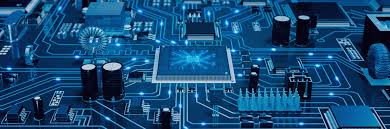

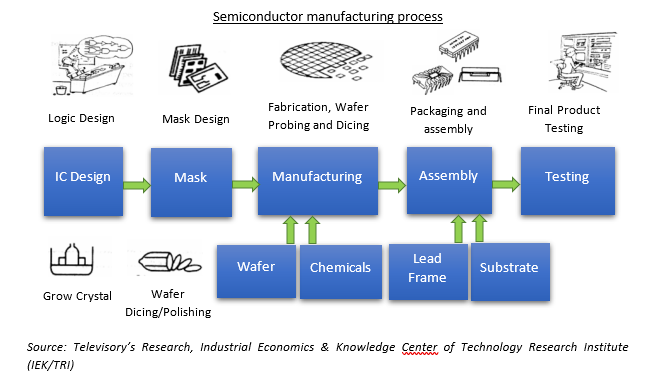


# Product entity yield type prediction

## Domain
### Semiconductor manufacturing process
## Business Context
#### A complex modern semiconductor manufacturing process is normally under constant
#### surveillance via the monitoring of signals/variables collected from sensors and or
#### process measurement points. However, not all of these signals are equally valuable in
#### a specific monitoring system.
#### The measured signals contain a combination of useful information, irrelevant
#### information as well as noise. Engineers typically have a much larger number of signals
#### than are actually required. If we consider each type of signal as a feature, then feature
#### selection may be applied to identify the most relevant signals. The Process Engineers
#### may then use these signals to determine key factors contributing to yield excursions
#### downstream in the process. This will enable an increase in process throughput,
#### decreased time to learning and reduce the per unit production costs.
#### These signals can be used as features to predict the yield type. And by analyzing and
#### trying out different combinations of features, essential signals that are impacting the
#### yield type can be identified.

## Objective
#### We will build a classifier to predict the Pass/Fail yield of a particular process entity and
#### analyze whether all the features are required to build the model or not.

## Dataset description 

#### sensor-data.csv : (1567, 592)
#### The data consists of 1567 examples each with 591 features.
#### The dataset presented in this case represents a selection of such features where each
#### example represents a single production entity with associated measured
#### features and the labels represent a simple pass/fail yield for in house line
#### testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and
#### the data time stamp is for that specific test point.

## Steps
1. Import the necessary liberraries and read the provided CSV as a dataframe and
perform the below steps. 
a. Check a few observations and shape of the dataframe
b. Check for missing values. Impute the missing values if there is any
c. Univariate analysis - check frequency count of target column and
distribution of the first few features (sensors)
d. Perform bivariate analysis and check for the correlation
e. Drop irrelevant columns
2. Standardize the data 
3. Segregate the dependent column ("Pass/Fail") from the data frame. And split
the dataset into training and testing set ( 70:30 split) 
4. Build a logistic regression, random forest, and xgboost classifier model and print
confusion matrix for the test data 
5. Apply sampling techniques to handle the imbalanced classes 
6. Build a logistic regression, random forest, and xgboost classifier model after resampling the data and print the confusion matrix for the test data 
7. Apply Grid Search CV to get the best hyper parameters for any one of the above
model 
8. Build a classifier model using the above best hyper parameters and check the
accuracy and confusion matrix 
9. Report feature importance and mention your comments 

10. Report your findings and inferences 
Further Questions ( Optional) -
1. Check for outliers and impute them as required.
2. Apply PCA to get rid of redundant features and reduce dimension of the data
3. Try cross validation techniques to get better results
4. Try OneCLassSVM model to get better recall

### Learning Outcomes
* Feature Importance
* Sampling
* SMOTE
* Grid Search
* Random Forest
* Exploratory Data Analysis
* Logistic Regression

## Import Some Basic Libraries

In [1]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for modeling 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# for providing path
import os
print(os.listdir("../input"))


Using TensorFlow backend.


['uci-secom.csv']


## Reading the Data and understanding the attributes

In [2]:
# reading the data
data = pd.read_csv('../input/uci-secom.csv')

# getting the shape of the data
# we have 1,567 rows and 592 columns
print(data.shape)


(1567, 592)


In [3]:
# getting the head of the data

data.head()

,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,...,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,...,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
# checking if the dataset contains any NULL values
# we do have NaN values if we see the output above

data.isnull().any().any()

True

In [5]:
# Replacing all the NaN values with 0 as the values correspond to the test results.
# since, the values are not present that means the values are not available or calculated
# Absence of a signal is assumed to be no signal in the dataset
# so better we not take median or mean and replace them with zeros

data = data.replace(np.NaN, 0)

# again, checking if there is any NULL values left
data.isnull().any().any()

False

## Data Visualization

In [6]:
unique_vals = data['Pass/Fail'].unique()  # [0, 1, 2]
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]

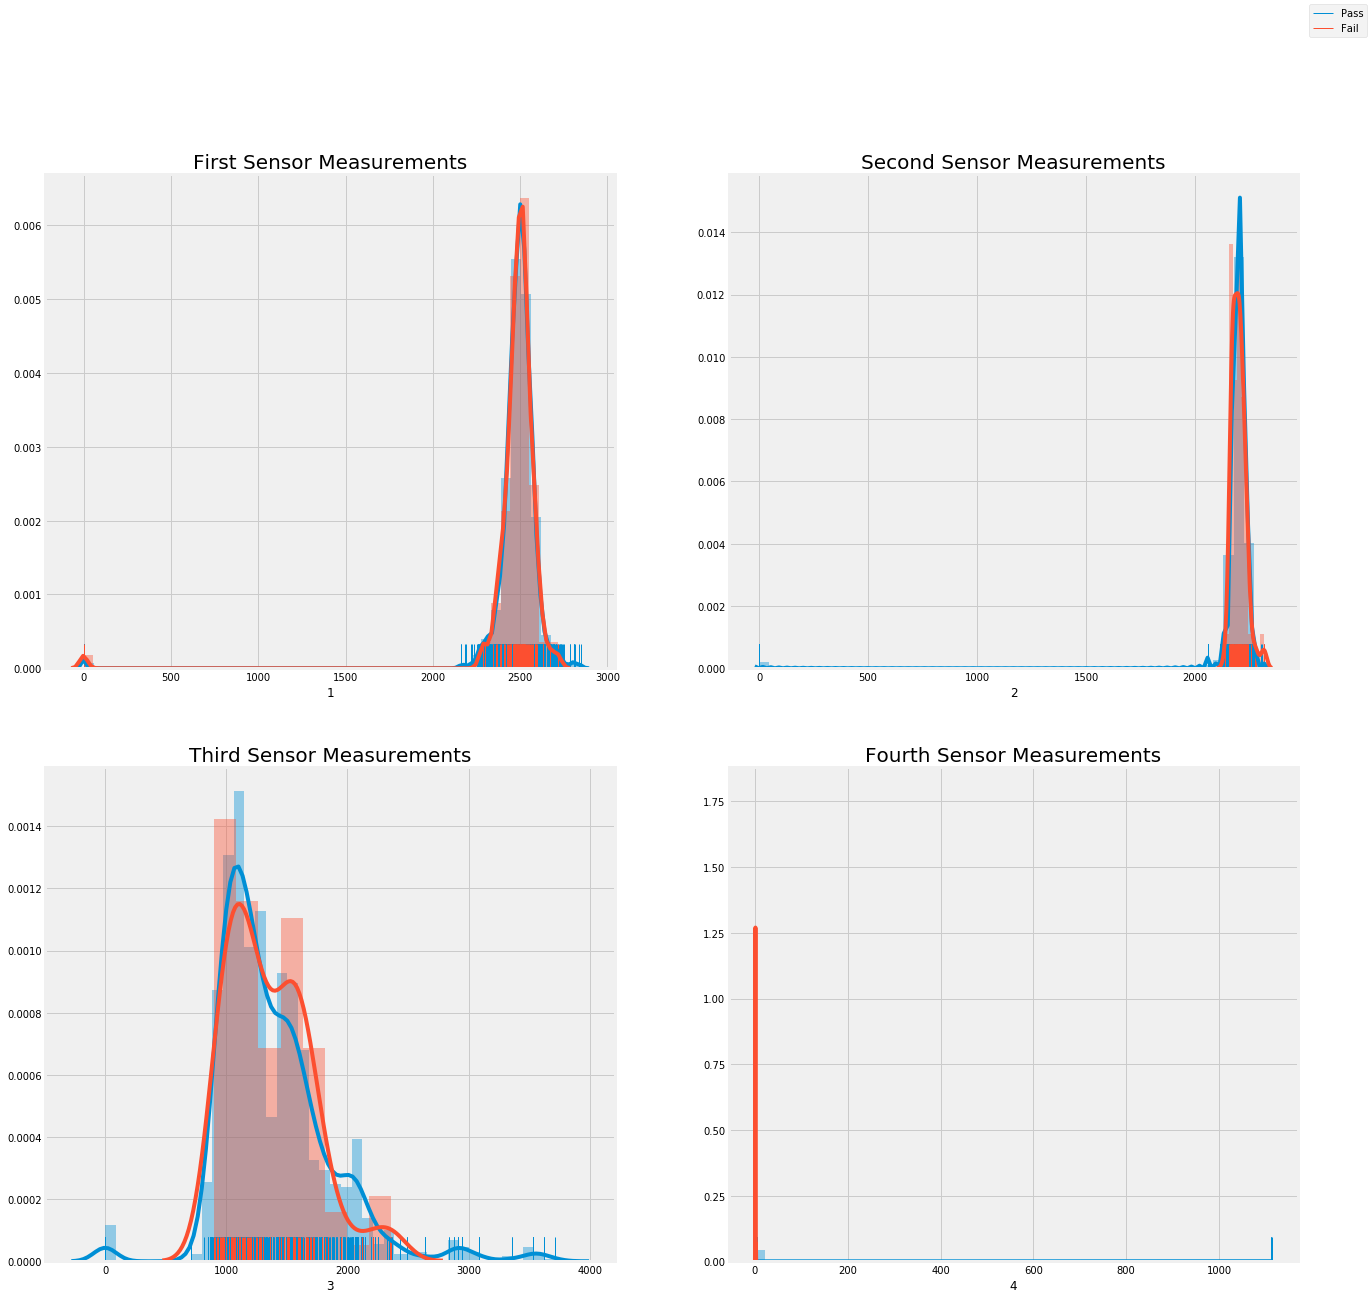

In [7]:
fig = plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize = 20)

#sns.add_legend()
#plt.legend()
fig.legend(labels=['Pass','Fail'])
plt.show()


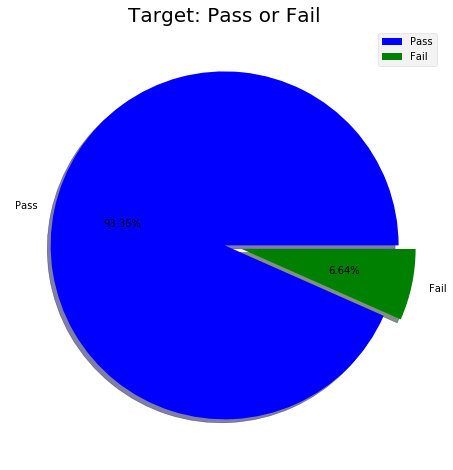

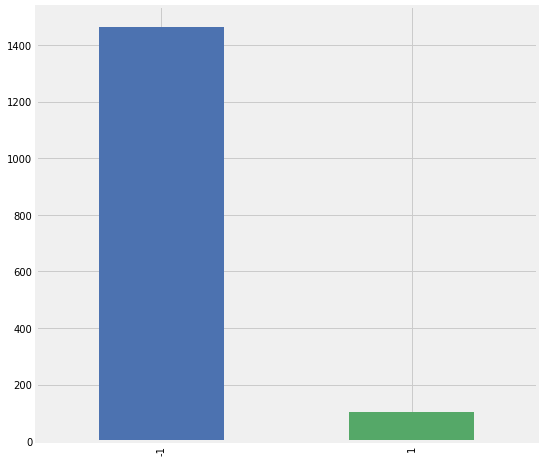

In [8]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass

labels = ['Pass', 'Fail']
size = data['Pass/Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind="bar");

Text(0.5, 1.0, 'Correlation heatmap for the Data')

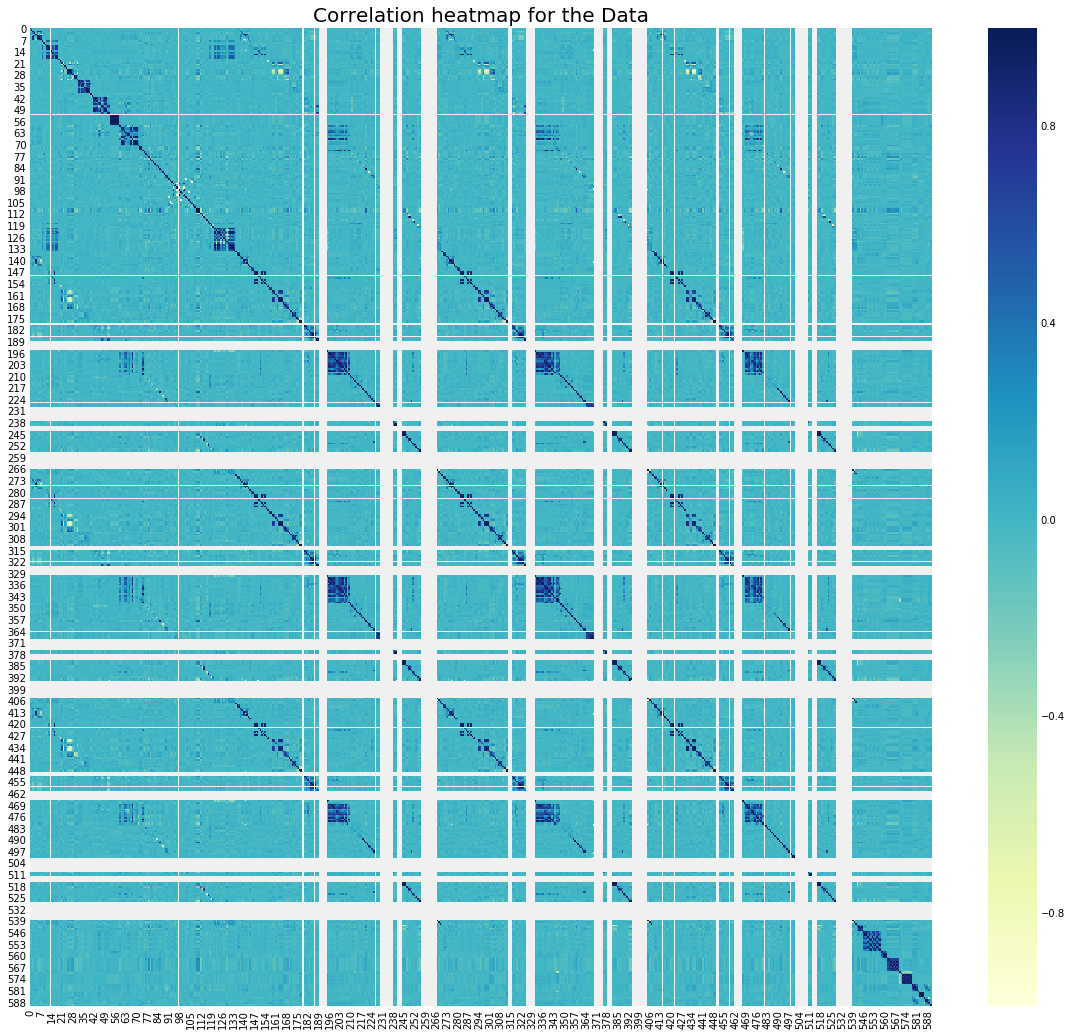

In [9]:
# heatmap to get correlation

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 20)

## Data Cleaning/Preprocessing

In [10]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [11]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
data = remove_collinear_features(data,0.70)

5 | 2 | 0.99
6 | 2 | 0.82
6 | 5 | 0.84
7 | 2 | 0.75
7 | 5 | 0.77
12 | 11 | 0.83
17 | 11 | 0.81
18 | 11 | 0.72
18 | 12 | 0.79
18 | 17 | 0.9
22 | 21 | 0.75
26 | 25 | 0.83
27 | 25 | 0.98
27 | 26 | 0.79
30 | 29 | 0.86
34 | 32 | 0.88
35 | 34 | 0.83
37 | 32 | 0.75
37 | 34 | 0.75
38 | 32 | 0.72
38 | 34 | 0.72
38 | 36 | 0.71
38 | 37 | 0.97
39 | 32 | 0.81
39 | 34 | 0.91
39 | 35 | 0.71
39 | 37 | 0.86
39 | 38 | 0.84
43 | 42 | 0.82
44 | 42 | 0.82
46 | 42 | 0.84
46 | 43 | 0.84
46 | 45 | 0.74
48 | 44 | 0.77
49 | 42 | 1.0
49 | 43 | 0.82
49 | 44 | 0.82
49 | 46 | 0.84
50 | 42 | 0.88
50 | 43 | 0.9
50 | 46 | 0.97
50 | 49 | 0.88
51 | 47 | 0.71
54 | 53 | 1.0
55 | 53 | 0.95
55 | 54 | 0.95
56 | 53 | 0.98
56 | 54 | 0.97
56 | 55 | 0.96
57 | 53 | 0.97
57 | 54 | 0.96
57 | 55 | 0.98
57 | 56 | 0.99
58 | 53 | 0.93
58 | 54 | 0.93
58 | 55 | 0.92
58 | 56 | 0.96
58 | 57 | 0.94
61 | 60 | 0.88
65 | 64 | 0.85
66 | 60 | 0.97
66 | 61 | 0.84
66 | 62 | 0.75
68 | 60 | 0.85
68 | 61 | 0.87
68 | 66 | 0.85
69 | 60 | 0.96
69 | 61 |

In [12]:
# deleting the first column

data = data.drop(columns = ['Time'], axis = 1)

# checking the shape of the data after deleting a column
data.shape

(1567, 307)

In [13]:
data.head()

,0,1,2,3,4,8,9,10,11,13,14,15,16,19,20,21,23,24,25,28,29,31,32,33,36,40,41,42,45,47,52,53,59,60,62,63,64,67,71,72,...,507,508,509,510,511,512,513,514,515,521,528,529,530,531,532,533,534,535,536,537,538,542,543,544,546,551,558,559,562,565,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,7.9558,414.8710,10.0433,12.5190,1.4026,-5419.00,-4043.75,751.00,0.8955,64.2333,2.0222,3.5191,83.3971,9.5126,49.3830,61.29,4.515,70.0,130.3691,1.3072,0.0,4.592,-1.7264,350.9264,108.6427,16.1445,21.7264,0.9226,84.0793,0.0000,...,0.0,0.0,0.0,64.6707,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.0616,0.78,1.0344,0.4385,0.000,0.0000,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,10.1548,414.7347,9.2599,12.4608,1.3825,-5441.50,-3498.75,-1640.25,1.2973,68.4222,2.2667,3.4171,84.9052,9.7997,49.3404,78.25,2.773,70.0,133.1727,1.2887,0.0,4.590,0.8073,352.0073,113.9800,10.9036,19.1927,1.1598,82.3494,0.0000,...,0.0,0.0,0.0,141.4365,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.3526,1.33,0.9634,0.1745,0.000,0.0000,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,9.5157,416.7075,9.3144,12.5404,1.4123,-5447.75,-4047.00,-1916.50,1.3122,67.1333,2.3333,3.5986,84.7569,8.6590,49.8470,14.37,5.434,70.0,131.8027,1.2992,0.0,4.486,23.8245,364.5364,115.6273,11.3019,16.1755,0.8694,84.7681,140.6972,...,0.0,0.0,0.0,240.7767,244.2748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,0.7942,0.85,1.5021,0.3718,267.064,0.6219,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,9.6052,422.2894,9.6924,12.4782,1.4011,-5468.25,-4515.00,-1657.25,1.3137,62.9333,2.6444,3.3813,84.9105,8.6789,49.4900,76.90,1.279,70.0,131.8027,1.3027,0.0,4.486,24.3791,361.4582,116.1818,13.5597,15.6209,0.9761,70.2289,160.3210,...,0.0,0.0,0.0,113.5593,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.1650,39.33,1.1613,0.7288,268.228,0.1630,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,10.5661,420.5925,10.3387,12.4735,1.3888,-5476.25,-3987.50,117.00,1.2887,62.8333,3.1556,3.2728,86.3269,8.7677,49.7520,76.39,2.209,70.0,176.3136,1.0341,0.0,4.624,-12.2945,355.0809,144.0191,21.9782,32.2945,0.9256,65.8417,0.0000,...,0.0,0.0,0.0,148.0663,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1096,0.0078,0.0026,1.4636,1.98,0.9778,0.2156,0.000,0.0000,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


In [14]:
# separating the dependent and independent data

x = data.iloc[:,:306]
y = data["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [15]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1096, 306)
shape of x_test:  (471, 306)
shape of y_train:  (1096,)
shape of y_test:  (471,)


In [16]:
# standardization

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


## XGBoost Algorithm (Normal data)

In [17]:
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

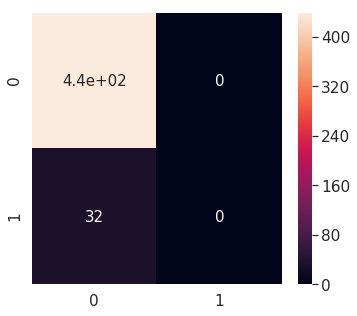

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [19]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  93.20594479830149


#### In the failure class we have only 1 observation classified correctly for XGBoost but still has 94.5% accuracy as we predicted correctly on the observations that passed

## Random Forest Classifier (Normal Data)

In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

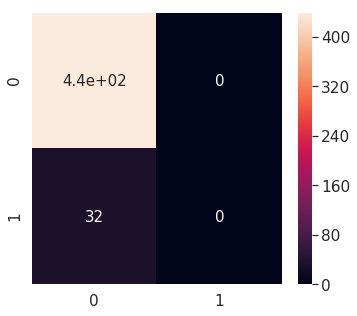

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [22]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  93.20594479830149


#### In the failure class we have no observation classified correctly for Random Forest but still has 94.5% accuracy as we predicted correctly on the observations that passed

## Logistic Regression (Normal Data)

In [23]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


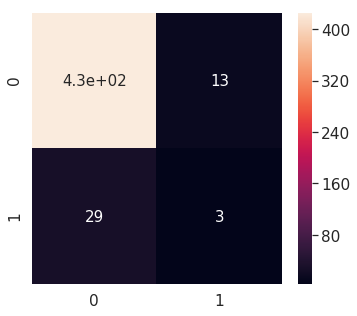

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [25]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

Accuracy:  91.0828025477707


#### In the failure class we have 4 observation classified correctly for logistic regression and 88% accuracy as we predicted correctly on the observations that passed. So even though this model has lesser accuracy it is preferable over previous models as at least it is classifying more observations in the failure class correctly

## Lasso (Normal Data)

In [26]:

lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train,y_train)
#print ("Lasso model:", (lasso.coef_))

y_pred = lasso.predict(x_test)

#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

In [27]:
print("Accuracy: ", lasso.score(x_test,y_test)*100)

Accuracy:  -0.007974076019068299


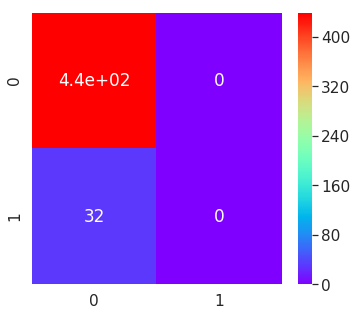

In [28]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## UnderSampling of the Dataset

In [29]:
# Under Sampling - Check how many failure observations are there
# We have 104 such observations

failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [30]:
# Check how many pass observations are there
# We have 1,463 such observations

normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [31]:
# Get 104 random observations from the pass class as well

random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [32]:
#Getting a 50-50 representation from both pass and fail classes
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [33]:
# creating the undersample data

undersample_data = data.iloc[under_sample, :]

In [34]:

# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 306)
(208, 1)


In [35]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [36]:
# standardization

sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

## Xg-Boost Classifier (Undersampling)

In [37]:


model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Confusion Matrix after UnderSampling with XgBoost

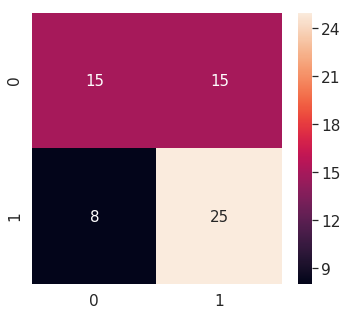

In [38]:


cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

# It is able to predict 26 defected semiconductors among 35 Semi-Conductors

In [39]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  43.31210191082803


## Grid Search - XG Boost (Undersampling)

In [40]:
# Applying Grid Search CV to find the best model with the best parameters



parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  75.17241379310344
Best Parameter:  {'cv': 2, 'max_depth': 3, 'random_state': 1}


In [42]:


weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

In [43]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  43.524416135881104


## Confusion matrix XG Boost - Grid Search (Undersample)

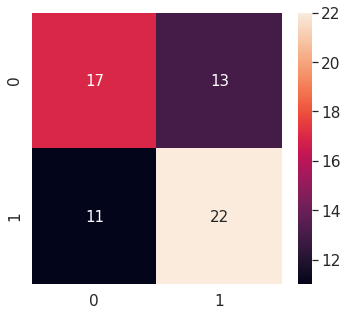

In [44]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

**Most Important Features of the Model**

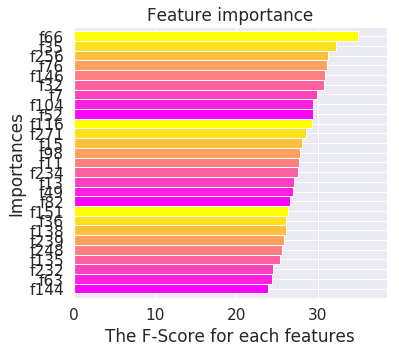

In [45]:
# plotting the feature importances

colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (100, 100)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

## Over-Sampling with SMOTE

In [46]:


x_resample, y_resample  = SMOTE(random_state=1).fit_sample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(218, 306)
(218,)


In [47]:


x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [48]:
# standardization



sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

## Xg-Boost Classifier - Grid Search (Oversampling)

In [49]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=1)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
# Applying Grid Search CV to find the best model with the best parameters

from sklearn.model_selection import GridSearchCV

# making a parameters list
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

# making a grid search model
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

# getting the results
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.7517241379310344
Best Parameter:  {'cv': 2, 'max_depth': 3, 'random_state': 1}


In [52]:


weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)


## Confusion Matrix after OverSampling with XgBoost

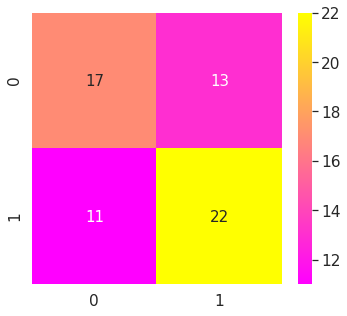

In [53]:


cm = confusion_matrix(y_test_os, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [54]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  43.524416135881104


## Random Forest (Oversampling)

In [55]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_os, y_train_os)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_os)
print("Accuracy: ", model.score(x_test_os,y_test_os)*100)

Accuracy:  66.66666666666666


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


## Random Forest - (Oversampled) - Confusion Matrix

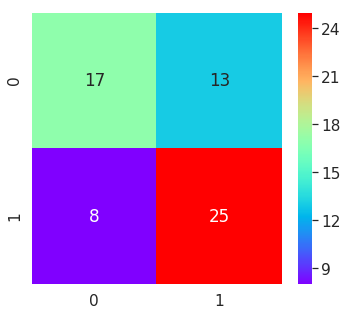

In [56]:
# printing the confusion matrix
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Logistic regression - (Oversampled)

In [57]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_os, y_train_os) 
y_pred = lr.predict(x_test_os)

print("Accuracy: ", lr.score(x_test_os,y_test_os)*100)

Accuracy:  60.317460317460316


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Logistic regression (Oversampled) - Confusion matrix

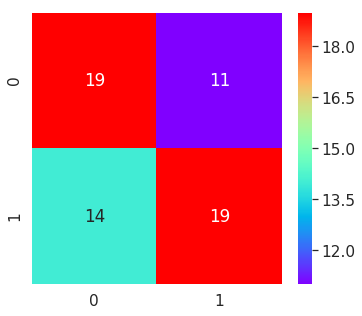

In [58]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Random Forest - (Undersampled)

In [59]:

model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_us)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


## Confusion Matrix for Random Forest (Undersampled)

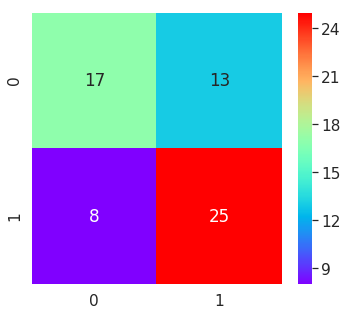

In [60]:
# evaluating the model

# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [61]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  49.469214437367306


## Using Lasso (Undersampled)

In [62]:

lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)
#print ("Lasso model:", (lasso.coef_))

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
y_pred = lasso.predict(x_test_us)

In [64]:
print(y_pred)

[-0.15164976  0.48416199 -0.06922546 -0.05203574  0.05537008  0.05943373
 -0.20781236  0.64170775 -0.09026198 -0.22654145  0.15710603  0.09950664
 -0.38770957 -0.23861507  0.27672312 -0.08121693 -0.13779582 -0.04493705
  0.31760248  0.02573193 -0.39515086  0.15488062  0.34387697  0.49294878
 -0.24049339  0.15987101  0.52212281  0.34315207  0.42348351 -0.29989748
 -0.40018732  0.09887507  0.62892515  0.4963479   0.05632047  0.48107788
  0.44101095  0.6506421   0.37609724 -0.19632962  0.79239952 -0.10389559
  0.04074038  0.3191246  -0.12444543  0.24092721 -0.20433085  0.28443319
  0.43023029 -0.50842598 -0.39287884  0.01270239 -0.15076683  0.90510171
 -0.03914651 -0.33045577  0.30046242 -0.12564144 -0.51923855  0.25976613
  0.4863474   0.20425686  0.11872133]


In [65]:
print(y_test_us)

      Pass/Fail
1349         -1
1297         -1
1117         -1
781          -1
495           1
238           1
636          -1
131           1
655          -1
583           1
23            1
327           1
1218         -1
1332         -1
94           -1
586          -1
231           1
1281         -1
236           1
277           1
1076         -1
508           1
218           1
57            1
1370         -1
786          -1
240           1
321           1
368           1
420          -1
...         ...
96            1
1329          1
1144          1
244           1
188           1
826           1
1446         -1
84           -1
637          -1
924           1
803          -1
633          -1
16           -1
1238          1
1324          1
76           -1
928          -1
539          -1
225          -1
795           1
64            1
293          -1
611          -1
154           1
1365          1
1302          1
273           1
14            1
455          -1
441           1

[63 row

In [66]:
#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

## Confusion matrix for Lasso (Undersampled)

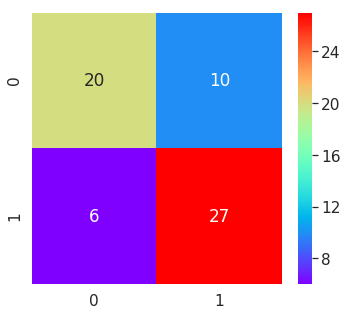

In [67]:
cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [68]:
print("Accuracy: ", lasso.score(x_test_us,y_test_us)*100)

Accuracy:  16.765792716379334


## Logistic Regression (Undersampled)

In [69]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us) 

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
y_pred = lr.predict(x_test_us)

## Confusion matrix for Logistic Regression (Undersampled)

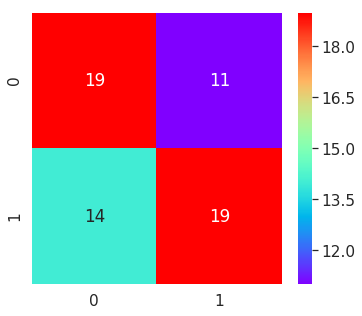

In [71]:
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [72]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

Accuracy:  55.62632696390658


> **Local Outlier Factor Classifier,** Succesfully detected 11 defected items out of 13, that makes an impeccable accuracy of 85% Recall Accuracy. This algorithm would have been worked even better if the data was a little bigger with more instances of defected items.

## One Class SVM (Undersampled)

> In one-class SVM, the support vector model is trained on data that has only one class, which is the “normal” class. It infers the properties of normal cases and from these properties can predict which examples are unlike the normal examples. This is useful for anomaly detection because the scarcity of training examples is what defines anomalies: that is, typically there are very few examples of the network intrusion, fraud, or other anomalous behavior.

In [73]:


model = OneClassSVM(kernel ='rbf', degree=3, gamma=0.1,nu=0.005, max_iter=-1, random_state=1)

model.fit(x_train_us, y_train_us)
y_pred = model.fit_predict(x_test_us)


## Confusion Matrix for One Class SVM

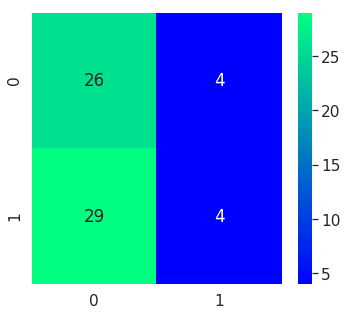

In [74]:

# evaluating the model
# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm ,annot = True, cmap = 'winter')


In [75]:
#print("Accuracy: ", model.score(x_test,y_test)*100)

## OneClassSVM - (Oversampled) 

In [76]:
model = OneClassSVM(kernel ='rbf', degree=3, gamma=0.1,nu=0.005, max_iter=-1, random_state=1)

model.fit(x_train_os, y_train_os)
y_pred = model.fit_predict(x_test_os)

## Confusion matrix for OneClassSVM - (Oversampled)

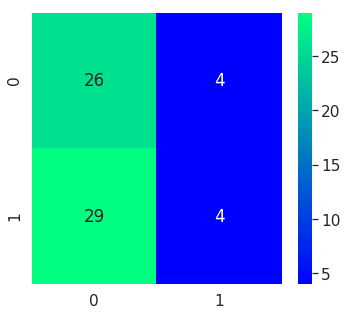

In [77]:
# evaluating the model
# printing the confusion matrix
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm ,annot = True, cmap = 'winter')

## Using PCA for demensionality reduction

In [78]:
#Scaling the data before applying PCA
from scipy.stats import zscore
data_new=data.iloc[:,:306].apply(zscore)
data_new.head()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,0,1,2,3,4,8,9,10,11,13,14,15,16,19,20,21,23,24,25,28,29,31,32,33,36,40,41,42,45,47,52,53,59,60,62,63,64,67,71,72,...,506,507,508,509,510,511,512,513,514,515,521,528,529,530,531,532,533,534,535,536,537,538,542,543,544,546,551,558,559,562,565,570,571,572,578,582,583,586,587,589
0,0.139998,0.429208,0.032735,0.059342,-0.049911,0.436850,1.128343,-0.381523,-0.481360,NaN,-0.365993,0.103291,0.063399,0.115613,-0.146683,0.292325,-0.174886,0.361808,-1.680570,-1.216514,-0.817788,-0.271316,-0.637696,0.409564,-0.001649,-0.220482,0.510332,0.02527,-0.733509,0.677628,NaN,0.045150,-0.491426,-0.126309,-0.660718,0.309530,0.247765,-0.051265,-0.615861,-0.972458,...,NaN,NaN,NaN,NaN,0.238101,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,0.370338,-0.186148,0.457482,0.560984,-2.171890,-1.305710,0.190142,0.034410,-0.226018,-0.662093,0.055275,-0.204269,-1.734706,-1.868461,-1.061159
1,0.464020,-0.105874,0.236852,0.173847,-0.059375,0.393723,0.022511,-1.608226,-0.011526,NaN,0.413621,0.097826,-0.257726,0.058404,-1.348004,0.258108,0.218468,-0.462781,0.520326,-0.232288,-0.231388,-0.456551,-0.127751,0.620277,-0.026434,0.450272,-0.222386,0.02527,-0.406395,0.581191,NaN,0.036752,-0.224999,-0.078785,-0.185041,-0.422165,-0.244190,-0.050492,-0.669532,-0.972458,...,NaN,NaN,NaN,NaN,2.273884,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,0.924510,0.229177,-0.354020,-0.749637,-2.171890,-1.305710,0.256816,1.205944,-0.261137,0.083539,0.162312,0.407145,-0.958144,0.412587,1.156951
2,-0.351256,0.407233,0.026413,0.684661,-0.047236,-0.192349,0.327111,0.124224,-0.044305,NaN,0.187040,0.176936,-0.235386,0.136649,0.433058,0.248603,-0.177232,-0.558042,0.601942,-0.535129,-0.071657,-0.126942,-0.177897,-0.216922,0.268308,-2.076132,0.896880,0.02527,-0.566241,0.635925,NaN,-0.399924,2.195341,0.472083,-0.038229,-0.366557,-0.830023,-0.051438,-0.594491,0.872171,...,NaN,NaN,NaN,NaN,4.908328,-0.095153,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,-0.138891,-0.133288,5.803114,0.229853,0.501601,5.447531,0.257279,-0.263745,-0.199823,3.873831,-0.304064,0.022827,2.989383,3.624211,-0.178407
3,-0.070903,-0.025985,0.086766,-1.033387,-0.050620,0.300837,-0.765478,-0.370762,-0.006063,NaN,0.218770,0.400773,-0.080439,0.075508,-0.236334,0.217428,-0.515011,-0.468643,0.610159,-1.521962,0.674474,-0.521564,-0.125959,-0.202317,0.060604,0.396881,-0.850790,0.02527,-0.566241,0.654170,NaN,-0.399924,2.253659,0.336744,0.011190,-0.051340,-0.937707,-0.051090,-1.045574,1.129451,...,NaN,NaN,NaN,NaN,1.534598,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,0.567250,28.924325,1.907900,2.002170,0.513254,0.464315,0.002548,-0.278290,-0.221613,0.906840,-0.059408,-0.291614,-0.100689,-0.177535,-0.274469
4,0.146544,0.098340,0.250931,-0.125070,-0.046823,0.465600,-0.149655,-0.790424,-0.169959,NaN,0.559439,0.332726,0.184487,0.070888,-0.971470,0.205262,-0.134288,0.143182,0.473219,-1.545458,1.900518,-0.718603,0.352978,-0.137143,0.213037,0.376711,-0.459614,0.02527,4.627127,-0.745981,NaN,0.179512,-1.602699,0.056353,2.492136,1.123988,2.299714,-0.051255,-1.181688,-0.972458,...,NaN,NaN,NaN,NaN,2.449703,-0.836511,NaN,NaN,NaN,NaN,-0.112621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.304202,-0.422665,0.304675,1.135896,0.720015,-0.189434,-0.545597,-2.171890,-1.305710,0.085279,-0.270290,-0.227409,-0.662093,-1.512057,26.860983,-0.100689,-0.177535,-0.274469


In [79]:
data_new.isnull().any().any()

True

In [80]:
data_new = data_new.replace(np.NaN, 0)

In [81]:
data_new.isnull().any().any()

False

In [82]:
# separating the dependent and independent data

x = data_new.iloc[:,:306]
y = data["Pass/Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [83]:
# PCA
# Step 1 - Create covariance matrix

cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00063857 -0.04781282  0.00759455 ...  0.04477373  0.00523674
   0.02150242]
 [-0.04781282  1.00063857 -0.03046719 ... -0.00922529  0.03950455
   0.04449214]
 [ 0.00759455 -0.03046719  1.00063857 ...  0.01574304 -0.00709495
  -0.03045388]
 ...
 [ 0.04477373 -0.00922529  0.01574304 ...  1.00063857  0.16974222
  -0.48505059]
 [ 0.00523674  0.03950455 -0.00709495 ...  0.16974222  1.00063857
   0.39175294]
 [ 0.02150242  0.04449214 -0.03045388 ... -0.48505059  0.39175294
   1.00063857]]


In [84]:
# Step 2- Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-0.0253695  -0.008654    0.00303277 ...  0.          0.
   0.        ]
 [-0.0025788   0.00538507  0.03440905 ...  0.          0.
   0.        ]
 [ 0.02753407  0.00681287  0.01400105 ...  0.          0.
   0.        ]
 ...
 [-0.048536   -0.05395333  0.04823939 ...  0.          0.
   0.        ]
 [ 0.01242541  0.02265625 -0.00838096 ...  0.          0.
   0.        ]
 [ 0.0256921   0.06086426 -0.04287574 ...  0.          0.
   0.        ]]

 Eigen Values 
%s [7.98315826 4.02662836 3.83340365 3.77872193 3.24842052 3.04338189
 2.81987221 2.70184859 2.63844411 2.49433697 2.39544185 2.33496444
 2.2688959  2.21004546 2.18253643 2.11987395 2.06331064 2.02389709
 2.01071359 1.99863763 1.98267329 1.95915582 1.92095551 1.8898469
 1.85708597 1.83222209 1.79047783 1.77162466 1.74830769 1.69223045
 1.6721054  1.64351825 1.63509768 1.61120278 1.59353955 1.58746461
 1.51376615 1.54878319 1.54342972 1.4987913  1.46908609 1.45916185
 1.45031371 1.42330375 1.39927034 1.37348926 1.3654

In [85]:
tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

Cumulative Variance Explained [  4.11240397   6.18666104   8.16138131  10.10793312  11.78130812
  13.34906055  14.80167533  16.19349202  17.55264684  18.83756703
  20.07154289  21.27436472  22.44315234  23.58162404  24.70592487
  25.79794607  26.86082953  27.90340969  28.93919857  29.96876671
  30.99011105  31.99934072  32.98889207  33.96241829  34.91906821
  35.86290988  36.78524762  37.69787343  38.59848786  39.47021494
  40.3315749   41.17820862  42.02050462  42.85049151  43.67137946
  44.48913799  45.28697037  46.08204499  46.86183886  47.63391867
  48.39069629  49.14236158  49.88946889  50.62266242  51.3434755
  52.05100785  52.75441472  53.44575446  54.13150394  54.80518611
  55.47224219  56.13386282  56.78335336  57.43035818  58.06247379
  58.68657041  59.30627663  59.91402001  60.51888826  61.11881541
  61.71313647  62.30277087  62.88054936  63.45680398  64.02642122
  64.58794689  65.14526769  65.69372362  66.23286709  66.7660594
  67.29318433  67.81743689  68.33600263  68.8483

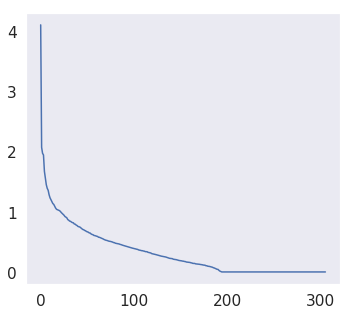

In [86]:
plt.plot(var_exp)

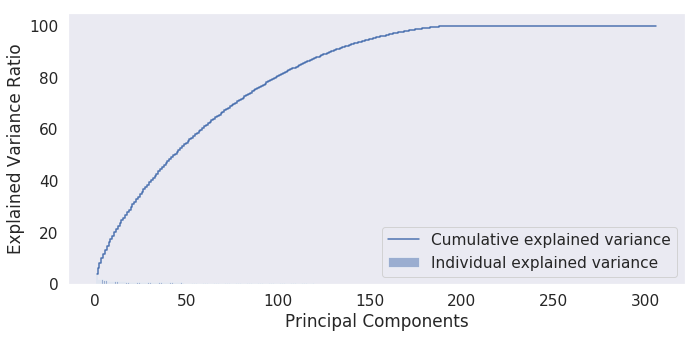

In [87]:
# Ploting 
plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [88]:
len(cum_var_exp)

306

In [89]:
# Using scikit learn PCA here. It does all the above steps and maps data to PCA dimensions in one shot
from sklearn.decomposition import PCA

# NOTE - we are generating only 130 PCA dimensions (dimensionality reduction from 306 to 130)
# For 130 components we are getting approximately 90% of the variance
pca = PCA(n_components=130)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

array([[ 3.2618515 ,  1.81271434,  2.21584421, ..., -5.38607942,
        -4.5716711 , -5.28922774],
       [ 0.08018959,  0.84611082,  0.26215877, ..., 34.89732096,
         4.06175432, 35.38547692],
       [-0.21079784, -0.95976375, -1.19297234, ...,  3.05918993,
         2.00010801,  5.14359353],
       ...,
       [-0.44462242, -1.40574967, -2.18413477, ...,  0.3638542 ,
         0.58523246,  0.04766754],
       [ 0.96121554, -0.1933783 ,  1.39250953, ..., -1.23871367,
        -1.05639745, -0.98132518],
       [-0.70106588,  0.80853033,  0.32164394, ..., -1.03472262,
         0.10764701, -1.38461066]])

In [90]:
pca.components_

array([[-0.0253695 , -0.00257878,  0.02753407, ..., -0.04853603,
         0.0124254 ,  0.02569209],
       [-0.008653  ,  0.00538495,  0.00681145, ..., -0.05395299,
         0.02265562,  0.06086412],
       [-0.00303236, -0.03441003, -0.01399823, ..., -0.04824049,
         0.00837948,  0.04287557],
       ...,
       [-0.06536513,  0.0527394 ,  0.04941063, ...,  0.01749304,
         0.06829948, -0.07245827],
       [-0.04830876,  0.01601789, -0.07965971, ..., -0.01887398,
         0.03425598,  0.00619392],
       [-0.05102201, -0.01388527, -0.03345244, ...,  0.06890834,
         0.02703331,  0.00608038]])

In [91]:
df_comp = pd.DataFrame(pca.components_,columns=list(x))
df_comp.head()

,0,1,2,3,4,8,9,10,11,13,14,15,16,19,20,21,23,24,25,28,29,31,32,33,36,40,41,42,45,47,52,53,59,60,62,63,64,67,71,72,...,506,507,508,509,510,511,512,513,514,515,521,528,529,530,531,532,533,534,535,536,537,538,542,543,544,546,551,558,559,562,565,570,571,572,578,582,583,586,587,589
0,-0.025369,-0.002579,0.027534,-0.066608,-0.024699,0.077981,-0.031003,0.017991,-0.011328,-1.744822e-19,0.005034,0.019391,0.027701,-0.039516,-0.050304,-0.052859,0.016272,0.058626,-0.202494,-0.190198,0.123875,0.167173,0.027159,0.043980,-0.005828,-0.056705,0.039729,-0.007907,-0.047040,-0.008641,5.739747e-21,0.001017,0.171374,0.009456,-0.011423,0.082010,0.013754,0.049314,-0.111448,0.097096,...,0.0,0.0,0.0,0.0,0.129524,0.019607,0.0,0.0,0.0,0.0,0.003645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.101994,-0.128223,0.091798,-0.026988,0.000649,-0.023092,-0.012600,-0.167819,-0.103563,-0.017317,0.095065,-0.020350,-0.006380,-0.012915,0.006665,-0.048536,0.012425,0.025692
1,-0.008653,0.005385,0.006811,0.043185,0.000093,-0.217424,0.002423,0.042956,-0.307620,-3.657605e-18,-0.038285,-0.288472,-0.076216,-0.020928,-0.004806,0.031166,-0.012395,-0.012609,-0.061741,-0.043703,0.033974,0.008655,-0.018982,-0.020480,-0.003106,0.001473,-0.009738,0.009797,-0.001829,0.015761,-5.658696e-19,-0.013668,0.004985,-0.001839,-0.035266,0.063348,0.080934,0.004047,0.025805,0.016827,...,-0.0,-0.0,-0.0,-0.0,0.053832,-0.024920,-0.0,-0.0,-0.0,-0.0,0.017052,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.012443,-0.000424,0.007629,-0.011563,0.008844,0.018328,0.007624,0.014049,0.013689,-0.015340,0.029585,0.013741,0.039334,0.006927,0.006353,-0.053953,0.022656,0.060864
2,-0.003032,-0.034410,-0.013998,-0.003742,-0.003487,-0.062301,-0.011086,-0.037444,-0.033605,-1.456523e-18,0.063054,-0.013857,0.017507,0.059027,-0.056334,-0.169488,-0.036784,0.044891,0.021635,0.064316,0.022333,0.130558,0.026913,0.040928,-0.026177,0.033885,-0.015741,0.056897,0.173768,-0.064407,4.968210e-19,0.033252,0.062353,0.133048,0.315843,0.102867,0.058527,0.270847,0.009621,-0.039069,...,0.0,0.0,0.0,0.0,-0.074749,0.040376,0.0,0.0,0.0,0.0,0.004301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003129,-0.003033,-0.013512,0.027577,-0.005282,0.039689,0.011629,-0.026317,-0.032972,-0.007389,-0.011178,-0.008239,-0.029701,-0.048941,0.013379,-0.048240,0.008379,0.042876
3,-0.011014,0.019492,0.031016,0.008150,0.037434,0.027088,-0.034176,0.030429,0.011599,1.000611e-17,-0.042480,0.037248,-0.026755,-0.024961,0.054692,0.244290,0.026842,-0.096050,0.082806,-0.059803,-0.053262,-0.253414,0.031540,0.045055,-0.030383,-0.073182,0.015130,0.020209,0.034121,0.111894,4.887053e-19,-0.014762,0.170913,0.060264,0.130654,0.300690,0.170089,0.269135,0.016509,0.072264,...,0.0,0.0,0.0,0.0,0.118449,0.015974,0.0,0.0,0.0,0.0,0.003134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003925,0.046981,0.030228,-0.006044,0.033548,-0.039092,-0.000984,0.033708,0.042442,-0.031514,-0.018144,0.031901,0.048756,0.010024,0.018016,0.021475,-0.018802,-0.007799
4,-0.001611,-0.024106,-0.050002,-0.037774,-0.030997,0.003795,-0.003774,-0.000669,-0.092510,-1.378955e-17,-0.133609,-0.108128,-0.019033,0.042283,0.032288,-0.052568,-0.015690,0.017752,0.103902,0.053302,-0.100585,-0.011655,0.002329,-0.015172,-0.008583,0.012024,0.002228,-0.041103,-0.113297,0.091880,-5.784219e-19,-0.000727,-0.021023,-0.080191,-0.039070,0.014704,-0.105293,0.046536,-0.090464,0.013507,...,0.0,0.0,0.0,0.0,-0.049405,-0.012688,0.0,0.0,0.0,0.0,-0.037831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.013364,0.019757,0.060034,-0.057710,-0.064311,-0.053665,-0.056219,-0.080539,-0.051722,-0.022403,0.033651,0.025765,-0.102885,-0.021629,-0.015481,0.035706,-0.088354,-0.083102


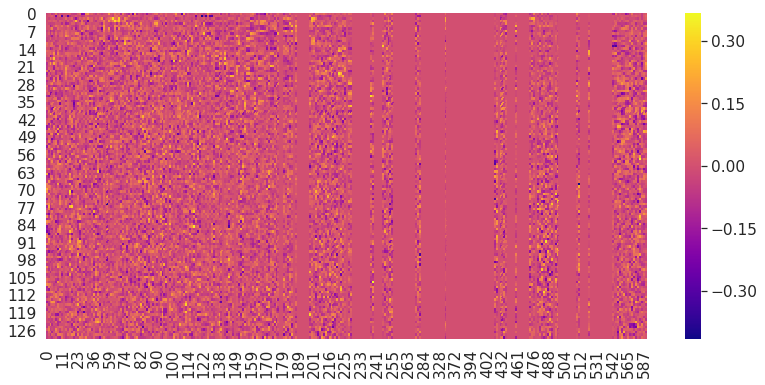

In [92]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [93]:
data_reduced.shape

(1567, 130)

In [94]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129
0,3.261851,0.080190,-0.210798,-0.872353,-0.619099,0.754293,-0.013391,-0.573276,-3.189953,1.890379,2.999126,-1.025372,-3.656188,-1.865129,0.020961,-0.186209,0.251257,3.304897,-0.087797,2.142477,0.542609,-1.609101,0.391458,-1.902174,0.780049,-0.304148,-0.731082,0.648403,1.531754,-1.375567,-2.407562,-0.101924,1.326177,-1.353352,0.861372,-2.581906,1.676931,2.076611,-2.344710,-3.129367,...,0.260705,0.535254,0.721620,0.387003,-0.093047,-0.718593,-0.739541,0.530239,-1.185217,0.340136,0.201904,-0.036912,-0.811575,0.975292,-0.833825,-1.106144,0.384738,1.242676,-0.307029,-0.835805,0.094855,-0.011185,1.262161,-0.104048,0.247134,-0.417080,0.604971,-0.066523,-0.933037,0.339211,0.572639,-0.924716,0.073824,0.866080,1.015361,-0.008513,0.359520,-0.444622,0.961216,-0.701066
1,1.812714,0.846111,-0.959764,-0.070734,0.165281,0.658320,-1.084048,0.301692,-2.560179,1.302074,0.133698,0.021536,-0.411381,-1.813524,-0.789942,-0.647924,-0.619034,0.280121,-0.453197,-2.468259,1.879349,-0.653416,2.706098,-1.818490,-0.162387,0.958521,0.049723,1.087582,0.198098,0.507457,-0.713299,-0.268671,-1.026562,1.471307,0.369664,0.856853,-0.082466,0.029260,0.849116,-1.139812,...,1.424361,-0.409115,2.132535,1.335151,-1.634945,-0.182371,1.083672,0.289601,-0.426124,2.610847,-0.776717,0.133885,-0.874916,-0.106588,-0.007960,0.511290,1.248122,-0.421372,0.170931,0.067869,-0.145535,0.034836,-0.700037,0.031196,-1.472205,0.336540,-0.305901,-1.890513,-0.891557,0.601204,0.107067,0.113137,-0.102119,1.050586,-1.275654,-0.017304,-0.106595,-1.405750,-0.193378,0.808530
2,2.215844,0.262159,-1.192972,2.265168,-1.238847,-0.950962,2.024419,0.906349,-1.153785,-1.811875,0.244516,-1.051245,-1.740701,-1.988639,-0.198236,-1.194832,-0.629501,1.514390,-0.329714,-2.436935,-2.559632,-0.650088,-2.021219,-1.185888,1.505882,-0.760527,-2.357703,-0.485834,3.156285,-1.203611,-0.967833,4.347885,-1.925643,0.605135,2.096403,1.730939,-0.743982,-2.045969,-0.060909,0.767995,...,-0.190494,0.055498,-0.126851,1.638470,-0.523806,-0.657732,-0.585135,-0.475582,1.047636,-0.209366,0.031995,-0.458441,0.391152,-0.213307,-1.462368,-0.067470,0.114092,-0.006968,0.136288,0.182356,-1.114965,0.460243,-0.499397,-1.701651,-0.064198,0.168768,0.100351,-0.211370,0.170457,-0.266802,-0.288488,0.812901,0.003296,0.086257,-0.744998,0.336217,0.319079,-2.184135,1.392510,0.321644
3,3.617114,0.816874,-0.816988,2.151992,-2.613168,-1.409962,1.174232,0.843490,-0.292268,-2.764951,-1.366559,3.246839,-0.941116,-2.732772,-0.283992,-1.537878,-4.799322,2.029420,0.103047,-3.904369,-0.927107,2.793492,1.502699,-1.064984,3.029649,-1.535279,0.315759,4.696627,2.917831,-2.039195,-1.098845,3.613113,-2.471407,-2.789674,4.382240,3.475860,-1.038308,-3.254774,2.434209,-2.497966,...,1.291819,-1.056492,-2.874868,-1.969253,3.692323,0.086674,-2.393937,0.911314,1.013016,1.576826,-0.862061,0.677320,-1.695056,-4.198412,-2.513530,0.772930,0.201562,0.824674,3.580261,-4.292853,2.547259,-0.404868,-2.837195,1.719632,-2.094626,4.354774,2.211674,-1.194922,3.782030,-1.251134,1.039525,-4.091067,-0.766201,-1.543521,-1.404944,1.520602,2.716795,4.764842,1.608163,1.065198
4,2.765991,0.133763,1.444752,2.269991,-1.497800,-0.623342,-2.928227,-1.896200,2.506345,1.485242,0.855872,0.166568,-0.596973,-2.914563,-0.810698,-0.560124,-5.659271,0.559319,-0.352779,-2.101818,-0.911357,-1.790665,1.613895,4.608553,-3.287902,-1.444071,2.343287,1.877507,1.330335,-4.266718,-1.722385,-1.571654,0.503428,-0.681496,-2.654378,3.598763,-0.795251,1.065274,-0.994546,-3.886865,...,-0.498083,0.661166,-1.266196,-0.576650,-2.438492,-0.639630,4.949980,-3.185866,-0.945113,-1.527707,-1.318000,1.856535,-1.951791,0.927312,-0.563474,-1.517055,-0.890764,1.218940,-0.502794,-0.189015,-1.541874,-1.708817,0.387232,0.485121,1.885631,-0.275462,-1.413328,1.313483,0.7

In [95]:
df_red3 = df_red2.copy()
df_red4 = df_red3
df_red4["Pass/Fail"] = data["Pass/Fail"]

In [96]:
df_red4.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,Pass/Fail
0,3.261851,0.080190,-0.210798,-0.872353,-0.619099,0.754293,-0.013391,-0.573276,-3.189953,1.890379,2.999126,-1.025372,-3.656188,-1.865129,0.020961,-0.186209,0.251257,3.304897,-0.087797,2.142477,0.542609,-1.609101,0.391458,-1.902174,0.780049,-0.304148,-0.731082,0.648403,1.531754,-1.375567,-2.407562,-0.101924,1.326177,-1.353352,0.861372,-2.581906,1.676931,2.076611,-2.344710,-3.129367,...,0.535254,0.721620,0.387003,-0.093047,-0.718593,-0.739541,0.530239,-1.185217,0.340136,0.201904,-0.036912,-0.811575,0.975292,-0.833825,-1.106144,0.384738,1.242676,-0.307029,-0.835805,0.094855,-0.011185,1.262161,-0.104048,0.247134,-0.417080,0.604971,-0.066523,-0.933037,0.339211,0.572639,-0.924716,0.073824,0.866080,1.015361,-0.008513,0.359520,-0.444622,0.961216,-0.701066,-1
1,1.812714,0.846111,-0.959764,-0.070734,0.165281,0.658320,-1.084048,0.301692,-2.560179,1.302074,0.133698,0.021536,-0.411381,-1.813524,-0.789942,-0.647924,-0.619034,0.280121,-0.453197,-2.468259,1.879349,-0.653416,2.706098,-1.818490,-0.162387,0.958521,0.049723,1.087582,0.198098,0.507457,-0.713299,-0.268671,-1.026562,1.471307,0.369664,0.856853,-0.082466,0.029260,0.849116,-1.139812,...,-0.409115,2.132535,1.335151,-1.634945,-0.182371,1.083672,0.289601,-0.426124,2.610847,-0.776717,0.133885,-0.874916,-0.106588,-0.007960,0.511290,1.248122,-0.421372,0.170931,0.067869,-0.145535,0.034836,-0.700037,0.031196,-1.472205,0.336540,-0.305901,-1.890513,-0.891557,0.601204,0.107067,0.113137,-0.102119,1.050586,-1.275654,-0.017304,-0.106595,-1.405750,-0.193378,0.808530,-1
2,2.215844,0.262159,-1.192972,2.265168,-1.238847,-0.950962,2.024419,0.906349,-1.153785,-1.811875,0.244516,-1.051245,-1.740701,-1.988639,-0.198236,-1.194832,-0.629501,1.514390,-0.329714,-2.436935,-2.559632,-0.650088,-2.021219,-1.185888,1.505882,-0.760527,-2.357703,-0.485834,3.156285,-1.203611,-0.967833,4.347885,-1.925643,0.605135,2.096403,1.730939,-0.743982,-2.045969,-0.060909,0.767995,...,0.055498,-0.126851,1.638470,-0.523806,-0.657732,-0.585135,-0.475582,1.047636,-0.209366,0.031995,-0.458441,0.391152,-0.213307,-1.462368,-0.067470,0.114092,-0.006968,0.136288,0.182356,-1.114965,0.460243,-0.499397,-1.701651,-0.064198,0.168768,0.100351,-0.211370,0.170457,-0.266802,-0.288488,0.812901,0.003296,0.086257,-0.744998,0.336217,0.319079,-2.184135,1.392510,0.321644,1
3,3.617114,0.816874,-0.816988,2.151992,-2.613168,-1.409962,1.174232,0.843490,-0.292268,-2.764951,-1.366559,3.246839,-0.941116,-2.732772,-0.283992,-1.537878,-4.799322,2.029420,0.103047,-3.904369,-0.927107,2.793492,1.502699,-1.064984,3.029649,-1.535279,0.315759,4.696627,2.917831,-2.039195,-1.098845,3.613113,-2.471407,-2.789674,4.382240,3.475860,-1.038308,-3.254774,2.434209,-2.497966,...,-1.056492,-2.874868,-1.969253,3.692323,0.086674,-2.393937,0.911314,1.013016,1.576826,-0.862061,0.677320,-1.695056,-4.198412,-2.513530,0.772930,0.201562,0.824674,3.580261,-4.292853,2.547259,-0.404868,-2.837195,1.719632,-2.094626,4.354774,2.211674,-1.194922,3.782030,-1.251134,1.039525,-4.091067,-0.766201,-1.543521,-1.404944,1.520602,2.716795,4.764842,1.608163,1.065198,-1
4,2.765991,0.133763,1.444752,2.269991,-1.497800,-0.623342,-2.928227,-1.896200,2.506345,1.485242,0.855872,0.166568,-0.596973,-2.914563,-0.810698,-0.560124,-5.659271,0.559319,-0.352779,-2.101818,-0.911357,-1.790665,1.613895,4.608553,-3.287902,-1.444071,2.343287,1.877507,1.330335,-4.266718,-1.722385,-1.571654,0.503428,-0.681496,-2.654378,3.598763,-0.795251,1.065274,-0.994546,-3.886865,...,0.661166,-1.266196,-0.576650,-2.438492,-0.639630,4.949980,-3.185866,-0.945113,-1.527707,-1.318000,1.856535,-1.951791,0.927312,-0.563474,-1.517055,-0.890764,1.218940,-0.502794,-0.189015,-1.541874,-1.708817,0.387232,0.485121,1.885631,-0.275462,-1.413328,1.313483,0.721407,2.082859,0.837155,0.567

In [97]:
df_red4.shape

(1567, 131)

In [98]:
#Causing system crash and taking too much time, so commented out
#sns.pairplot(df_red4,diag_kind='kde')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce1654f588>,
      dtype=object)

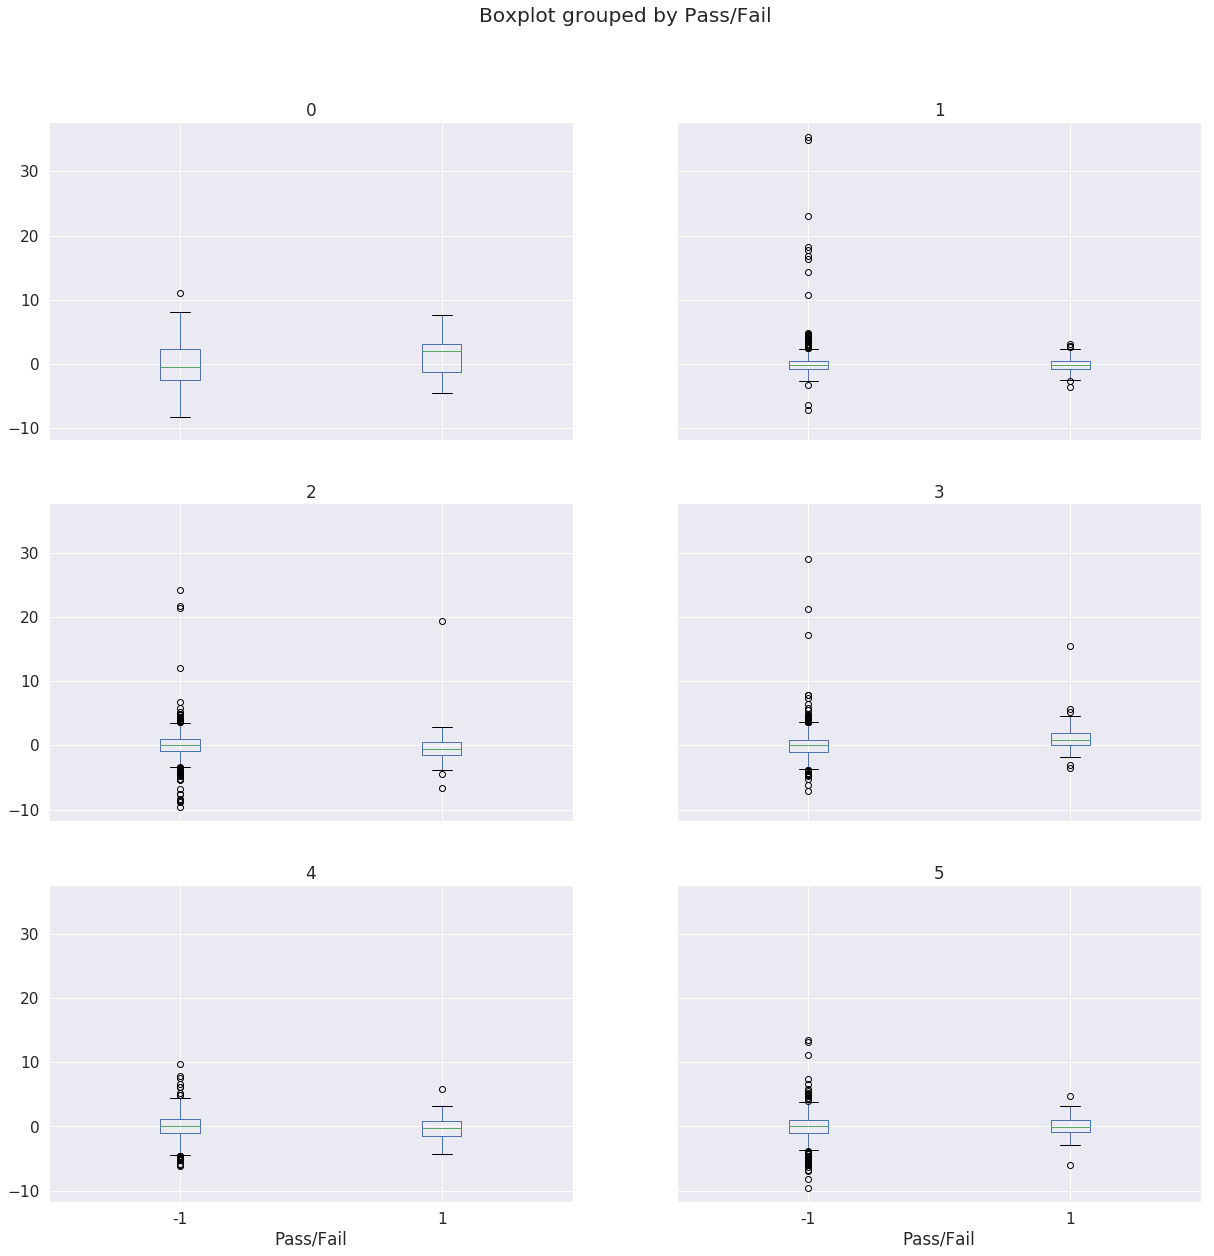

In [99]:
#Sample boxplot shows that there are outliers in the data, let us fix them
df_red4.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ]
                          , by = 'Pass/Fail', figsize=(20,20))

In [100]:
#Create a copy of the dataset for maintain data after outlier removal
#Here after identifying outliers we replace with median
pd_data = df_red4.copy()
#pd_data.head()

#pd_data2 = pd_data.drop(columns=['name'],axis=1)
#pd_data2 = pd_data2.apply(replace,axis=1)
from scipy import stats

#Define a function to remove outliers on max side
def outlier_removal_max(var):
    var = np.where(var > var.quantile(0.75)+ stats.iqr(var),var.quantile(0.50),var)
    return var

#Define a function to remove outliers on min side
def outlier_removal_min(var):
    var = np.where(var < var.quantile(0.25) - stats.iqr(var),var.quantile(0.50),var)
    return var

#Loop over the columns and remove the outliers on min and max side
for column in pd_data:
    pd_data[column] = outlier_removal_max(pd_data[column])
    pd_data[column] = outlier_removal_min(pd_data[column])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce16248e48>,
      dtype=object)

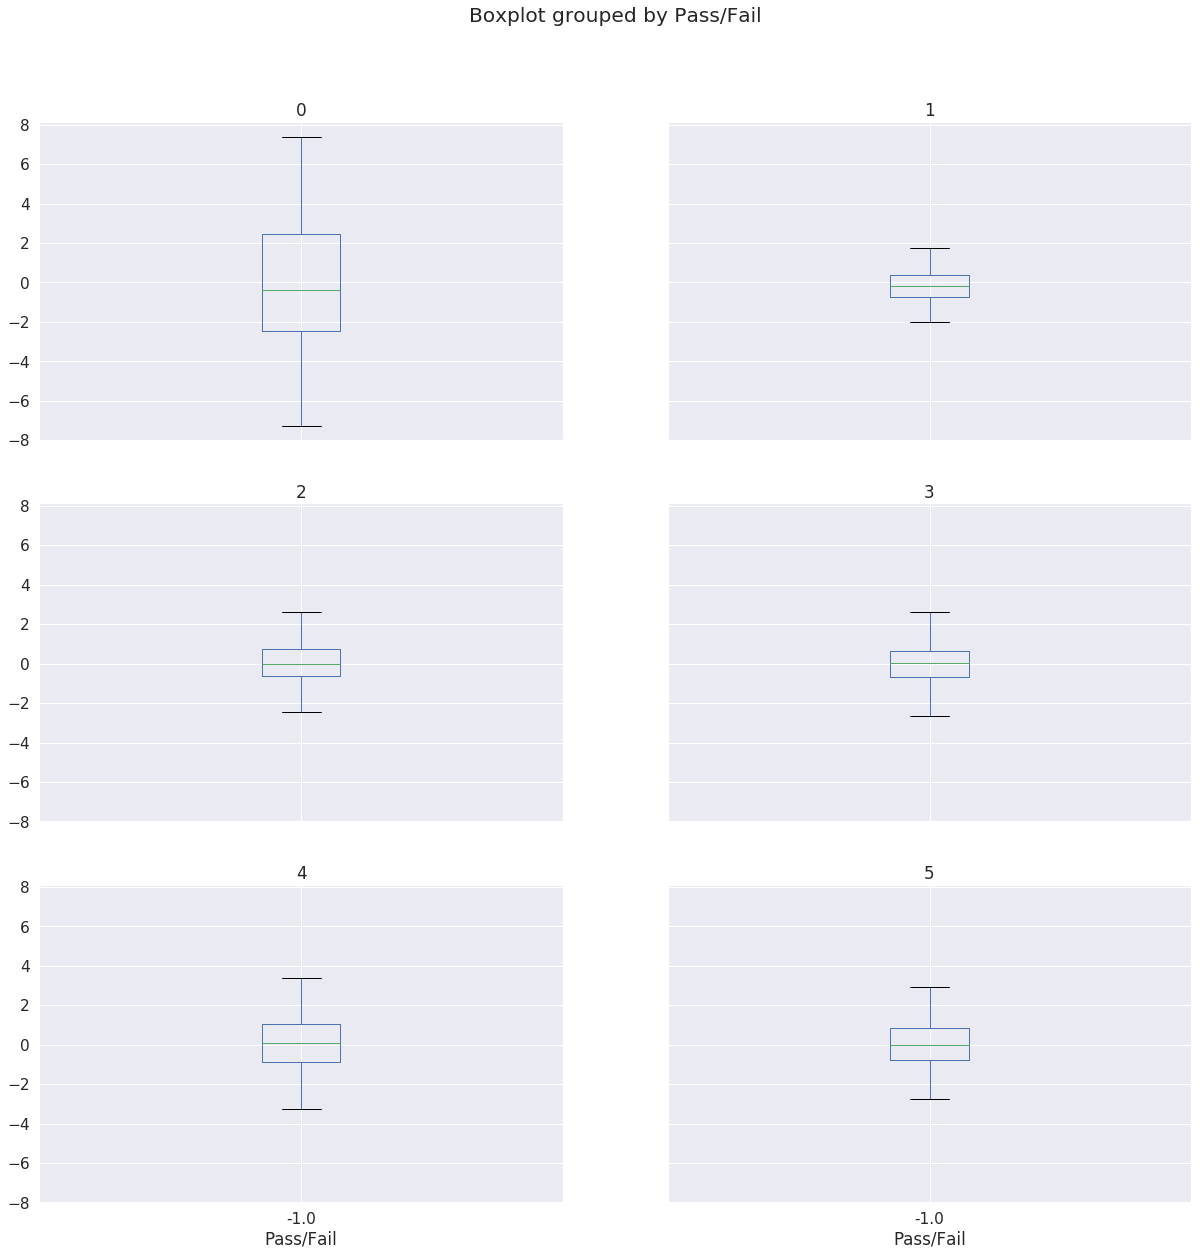

In [101]:
#Sample boxplot shows that outliers are fixed, but we are loosing observations belonging to failure 
#class (Pass/Fail = 1) So we should not remove outliers here 
pd_data.boxplot( column =[df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3], 
                          df_red4.columns[4],
                          df_red4.columns[5],
                         ],by = 'Pass/Fail', figsize=(20,20))

In [102]:
# separating the dependent and independent data

x = df_red4.iloc[:, df_red4.columns != 'Pass/Fail'] 
y = df_red4.iloc[:, df_red4.columns == 'Pass/Fail']

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 130)
shape of y: (1567, 1)


In [103]:
# Under Sampling - Check how many failure observations are there
# We have 104 such observations

failed_tests = np.array(df_red4[df_red4['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [104]:
# Check how many pass observations are there
# We have 1,463 such observations

normal_indices = df_red4[df_red4['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [105]:
# Get 104 random observations from the pass class as well

random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [106]:
#Getting a 50-50 representation from both pass and fail classes
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [107]:
# creating the undersample data

undersample_data = df_red4.iloc[under_sample, :]

# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 130)
(208, 1)


In [108]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 130)
(145, 1)
(63, 130)
(63, 1)


In [109]:
# standardization - completed before PCA itself

#sc = StandardScaler()
#x_train_us = sc.fit_transform(x_train_us)
#x_test_us = sc.transform(x_test_us)


## XGBoost - PCA (undersampled)

In [110]:
model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Confusion matrix for XG Boost - PCA - (Undersampled)

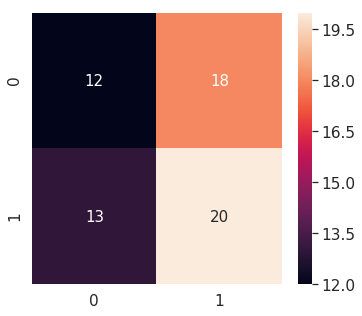

In [111]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})



In [112]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  50.79365079365079


## XG Boost - PCA - Grid Search - Undersampled

In [113]:
# Applying Grid Search CV to find the best model with the best parameters



parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
             'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Accuracy:  65.51724137931035
Best Parameter:  {'cv': 2, 'max_depth': 2, 'random_state': 1}


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [114]:
weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

print("Accuracy: ", model.score(x_test_us,y_test_us)*100)


Accuracy:  55.55555555555556


## Confusion matrix of XG Boost - Grid Search - PCA - Undersampled

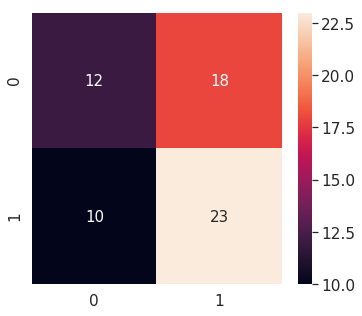

In [115]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})


## Random Forest - PCA - Undersampled

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


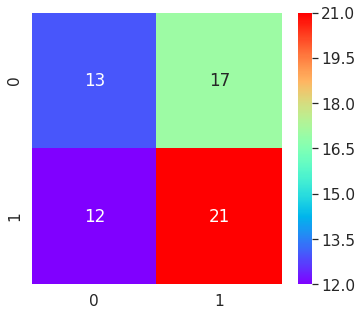

In [116]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_us, y_train_us)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test_us)

# evaluating the model

# printing the confusion matrix
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')



In [117]:
print("Accuracy: ", model.score(x_test_us,y_test_us)*100)

Accuracy:  53.96825396825397


## Logistic Regression - PCA - Undersampled

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


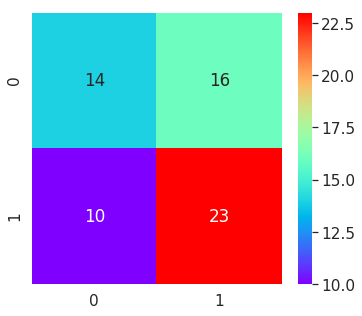

In [118]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_us, y_train_us) 
y_pred = lr.predict(x_test_us)
cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')


In [119]:
print("Accuracy: ", lr.score(x_test_us,y_test_us)*100)

Accuracy:  58.730158730158735


## Lasso - PCA - Undersampled

In [120]:
lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train_us,y_train_us)
#print ("Lasso model:", (lasso.coef_))

y_pred = lasso.predict(x_test_us)

#Convert the sign of the predicted values as the classifier
y_pred2 = np.sign(y_pred)

In [121]:
actual_cost = list(y_test_us)
actual_cost = np.asarray(actual_cost)
y_pred_lass = lasso.predict(x_test_us)

In [122]:
print("Accuracy: ", lasso.score(x_test_us, y_test_us)*100)

Accuracy:  -20.657192503789812


## Confusion Matrix for Lasso - PCA - Undersampled

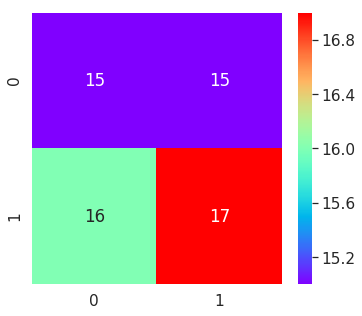

In [123]:

cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Elliptic Envelop technique

In [124]:
# defining outlier fraction for Elliptic Envelop, Isolation Forest and Local Outlier Factor

Fraud = data[data['Pass/Fail']==1]
Valid = data[data['Pass/Fail']==-1]

outlier_fraction = len(Fraud)/float(len(Valid))
print("Outlier Fraction :", outlier_fraction)

Outlier Fraction : 0.0710868079289132


In [125]:
from sklearn.covariance import EllipticEnvelope
model = EllipticEnvelope(contamination=outlier_fraction, random_state=1)
model.fit(x_train, y_train)
#scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test)

/opt/conda/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


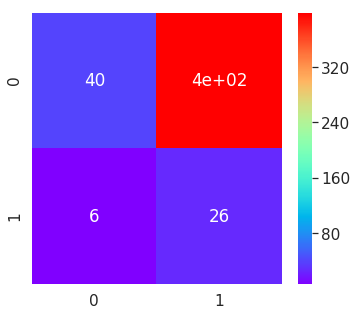

In [126]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Isolation Forest technique

In [127]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, max_samples=len(x_train), 
                                       contamination=outlier_fraction, random_state=1, verbose=0)
model.fit(x_train, y_train)
scores_prediction = model.decision_function(x_train)
y_pred = model.predict(x_test)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


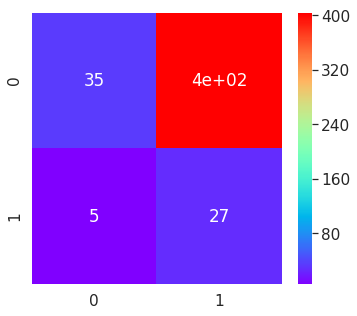

In [128]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Local Outlier Factor Technique

In [129]:
from sklearn.neighbors import LocalOutlierFactor


model = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, 
                           metric_params=None, contamination=outlier_fraction)

model.fit(x_train, y_train)
y_pred = model.fit_predict(x_test)

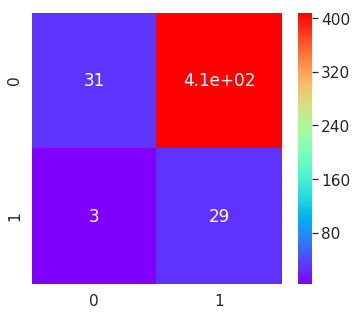

In [130]:
# printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

## Comparison of All Algorithms' Recall Rate

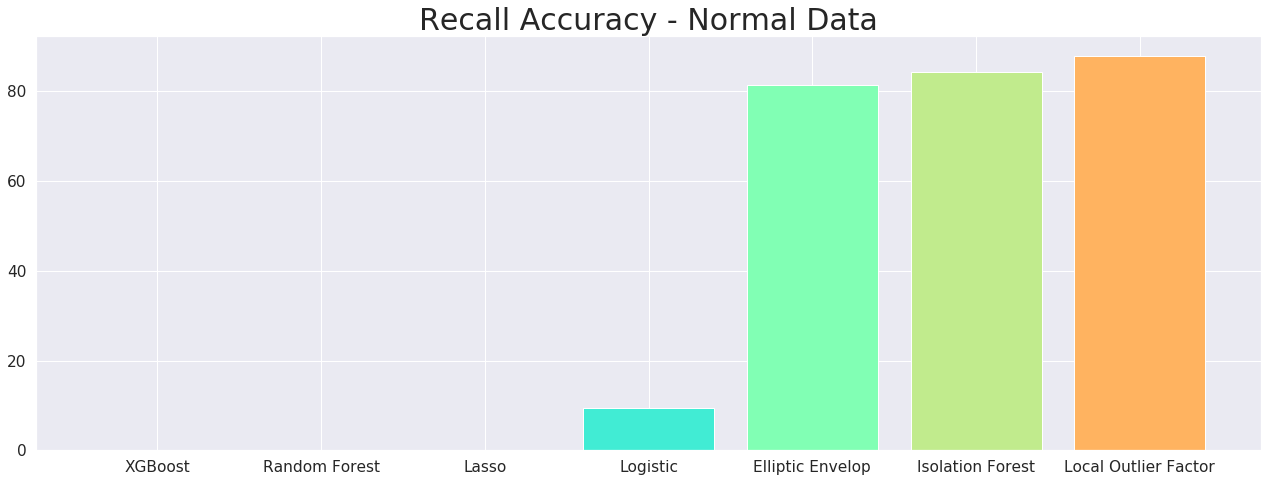

In [131]:
Recall = np.array([84.4, 87.9, 81.3,9.4,0,0,0])
label = np.array(['Isolation Forest', 'Local Outlier Factor', 'Elliptic Envelop',
                  'Logistic','XGBoost','Random Forest','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Normal Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

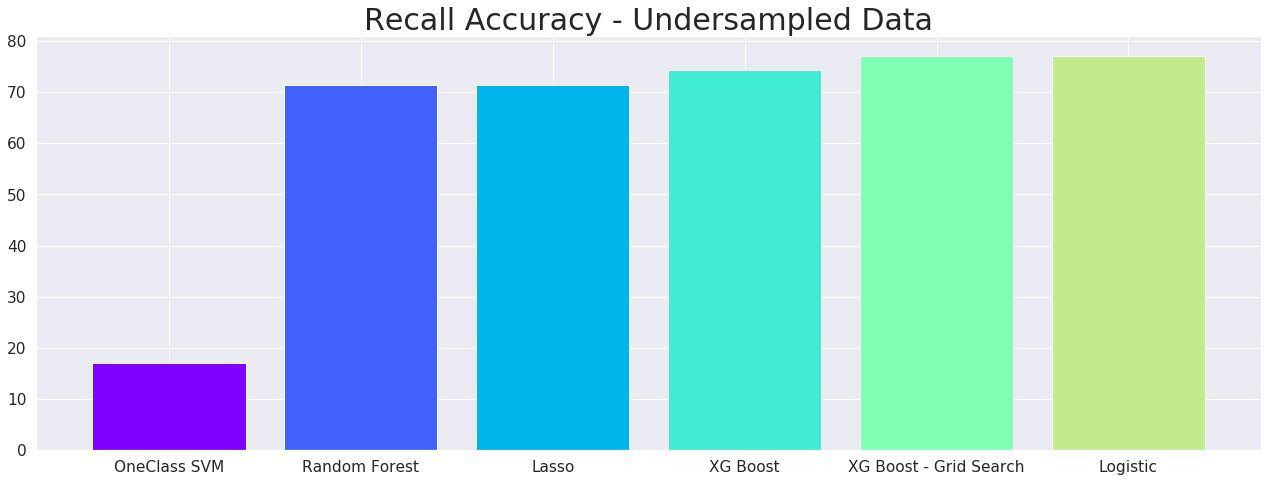

In [132]:
Recall = np.array([74.3,77.1,71.4,77.1,71.4,17.1])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso','OneClass SVM'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Undersampled Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

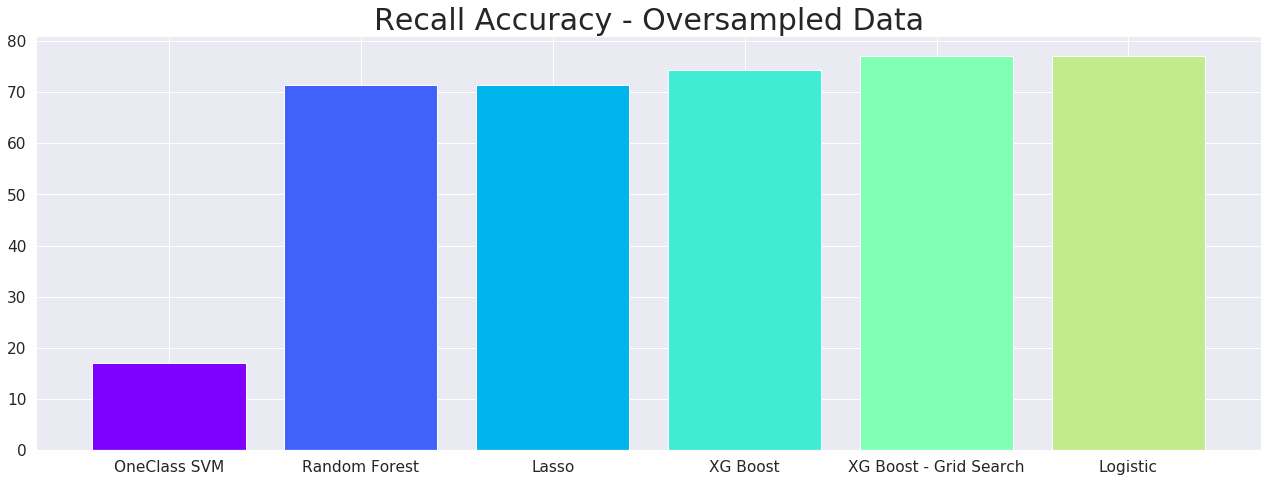

In [133]:
Recall = np.array([74.3,77.1,71.4,77.1,71.4,17.1])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso','OneClass SVM'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - Oversampled Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

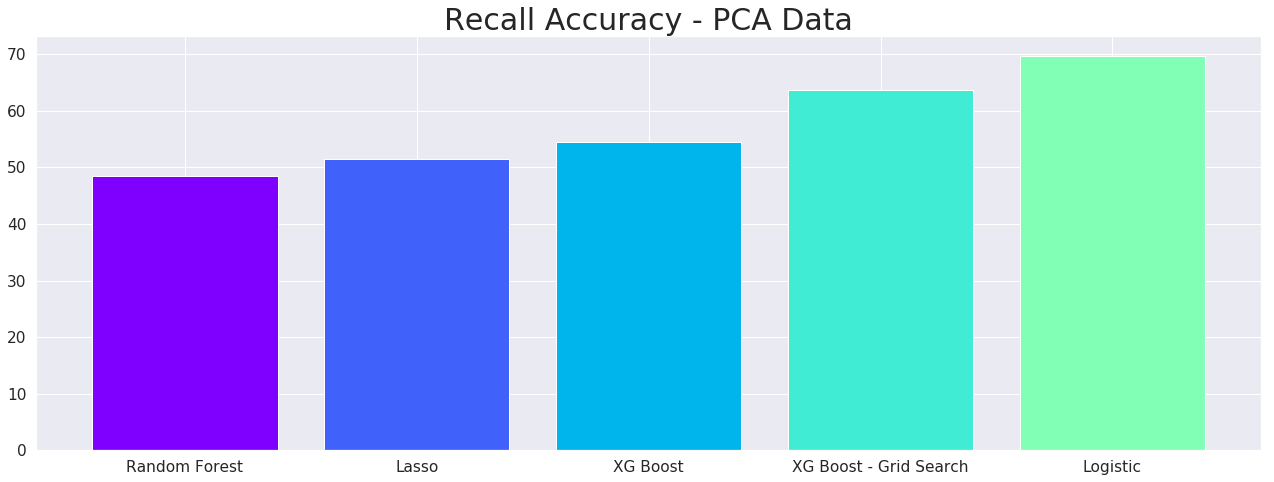

In [134]:
Recall = np.array([54.5,63.6,48.5,69.7,51.5])
label = np.array(['XG Boost','XG Boost - Grid Search','Random Forest','Logistic','Lasso'])
indices = np.argsort(Recall)
color = plt.cm.rainbow(np.linspace(0, 1, 9))

plt.rcParams['figure.figsize'] = (18, 7)
plt.bar(range(len(indices)), Recall[indices], color = color)
plt.xticks(range(len(indices)), label[indices])
plt.title('Recall Accuracy - PCA Data', fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 8000x8000 with 0 Axes>

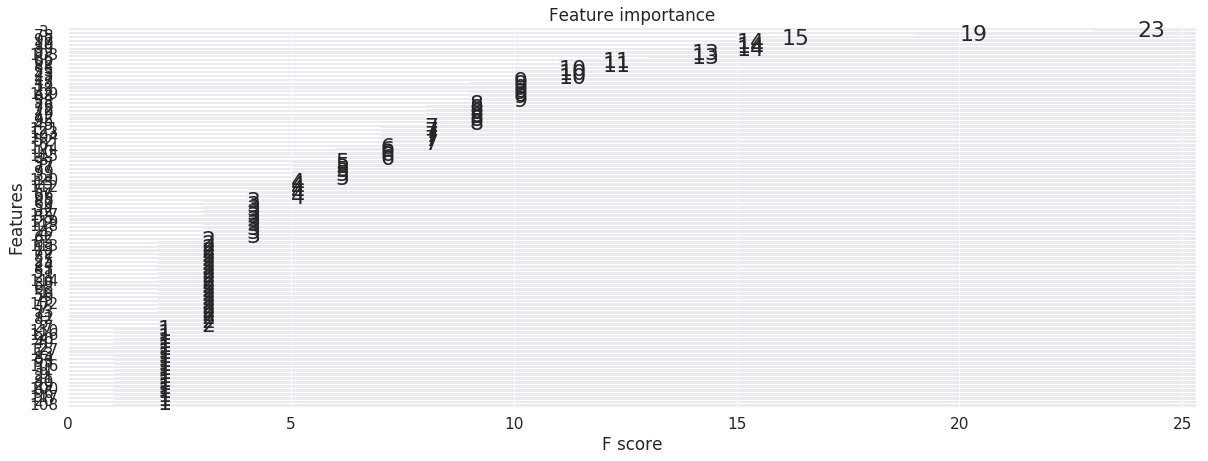

In [135]:
# plotting the feature importances

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
pyplot.rcParams.update({'font.size': 22})
from matplotlib.pyplot import figure
figure(num=None, figsize=(100, 100), dpi=80, facecolor='w', edgecolor='k')
# fit model no training data
model = XGBClassifier()
model.fit(x_train_us, y_train_us)
# plot feature importance
plot_importance(model)
pyplot.show()

In [136]:
featureImp = []
for feat, importance in zip(data.columns, model.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False))

    Feature  Importance
58       92    3.463618
0         0    3.418640
108     166    3.153037
45       79    2.925261
120     179    2.757236
3         3    2.742792
27       42    2.511115
52       86    2.383974
62       97    2.240678
33       60    2.225018
47       81    2.190199
96      149    2.168768
8        11    2.113077
95      146    1.917876
117     176    1.895175
98      151    1.781962
35       63    1.769045
42       76    1.661163
86      136    1.627162
104     159    1.503513
89      139    1.492951
20       29    1.477846
100     155    1.450818
109     167    1.407970
97      150    1.391734
94      145    1.381466
43       77    1.372523
78      120    1.329449
115     173    1.260155
16       23    1.249914
..      ...         ...
118     177    0.000000
111     169    0.000000
116     175    0.000000
65      102    0.000000
101     156    0.000000
91      142    0.000000
6         9    0.000000
11       15    0.000000
14       20    0.000000
17       24    0

## We have tried multiple models Logistic Regression, Random Forest, XG Boost (with and without Grid Search),OneClassSVM, Elliptic Envelop, Isolation Forest and Local Outlier Factor for the imbalanced classes
## Across methods OneClassSVM performed the worst while Local Outlier Factor performed the best in terms of recall accuracy
## We saw that for imbalanced classes accuracy and recall are invertially proportional to each other. Better recall models have lower accuracy and vice versa.
## We have tried two sampling techniques -first one using SMOTE (oversampling) and second one 
## using random based method (undersampling), Oversampling gave better results than undersampling in 
## terms of accuracy. Recall score was similar for both undersampling and oversampling.
## We did Z score scaling on both the datasets and took PCA with n_components as 130 (90% variance coverage). However PCA did not improve either accuracy or recall probably as we were loosing information due to dropping dimensions.
## We tried K-fold cross validation within XG Boost itself with bext value as 2 for all the models
## Using feature importance, we found that 72, 74 and 45 are the top three important 
## features. The best recall value at 88% was for Local Outlier Factor algorithm, the best part was no sampling was required as the algorithm took care of sampling as well as outliers. 
## classifier on the failure observations